In [170]:
import numpy as np

import matplotlib.pyplot as plt

In [171]:
import repeated_play

In [172]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["font.size"] = 12

plt.rcParams["font.family"] = "Arial"

In [182]:
import pandas as pd

import matplotlib.patches as mpatches

In [5]:
from tqdm.notebook import tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
import glob

In [7]:
def default_plot(ax, payoffs=None):
    if payoffs == None:
        R, S, T, P = 3, 0, 5, 1
    else:
        R, S, T, P = payoffs
    # labels of coordinates
    labels = ["(R, R)", "(S, T)", "(P, P)", "(T, S)"]

    # cordinates of corner points
    corner_points_x = [R, S, P, T]
    corner_points_y = [R, T, P, S]

    # lines coordinates
    x1 = [S * (1 - x) + R * x for x in np.linspace(0, 1)]
    y1 = [T * (1 - x) + R * x for x in np.linspace(0, 1)]
    x2 = [S * x + P * (1 - x) for x in np.linspace(0, 1)]
    y2 = [T * x + P * (1 - x) for x in np.linspace(0, 1)]

    # plotting
    ax.scatter(corner_points_x, corner_points_y, color="tab:blue", s=15)

    ax.fill(corner_points_x, corner_points_y, alpha=0.2)

    ax.plot(x1, y1, color="tab:blue")

    ax.plot(y1, x1, color="tab:blue")

    ax.plot(x2, y2, color="tab:blue")

    ax.plot(y2, x2, color="tab:blue")

    for i, txt in enumerate(labels):
        if i < 2:
            ax.annotate(
                txt, (corner_points_x[i] - 0.5, corner_points_y[i] + 0.5)
            )
        else:
            ax.annotate(
                txt, (corner_points_x[i] - 0.5, corner_points_y[i] - 0.5)
            )

    ax.set_ylim(S - 1, T + 1)
    ax.set_xlim(S - 1, T + 1)

    return ax

In [8]:
def match_payoffs(player, coplayer, Sx, Sy, memory="one"):
    M = repeated_play.transition_matrix_repeated_game(
        player, coplayer, memory=memory
    )

    ss = repeated_play.stationary_distribution(M)[0]

    return ss @ Sx, ss @ Sy

In [9]:
player = [1, 0.20, 0.4, 0.05]

mem2_player = [player[0], player[1], player[0], player[1],
               player[2], player[3], player[2], player[3]] * 2

In [10]:
b, c = 1, .5

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

In [76]:
np.random.seed(4801)

X, Y = [], []

for _ in range(10**3):
    
    q_1val, q_2val, q_3val, q_4val = np.random.random(4)

    q_player = [q_1val, q_2val, q_1val, q_2val,
                q_3val, q_4val, q_3val, q_4val] * 2

    payoffs_p1, payoffs_p2 = match_payoffs(mem2_player, q_player, Sx, Sy, memory='two')

    X.append(payoffs_p1)
    Y.append(payoffs_p2)

In [77]:
player = [1, 0.20, 0.4, 0.25]

mem2_player = [player[0], player[1], player[0], player[1],
               player[2], player[3], player[2], player[3]] * 2

In [82]:
np.random.seed(4801)

X1, Y1 = [], []

for _ in range(10**3):
    
    q_1val, q_2val, q_3val, q_4val = np.random.random(4)

    q_player = [q_1val, q_2val, q_1val, q_2val,
                q_3val, q_4val, q_3val, q_4val] * 2

    payoffs_p1, payoffs_p2 = match_payoffs(mem2_player, q_player, Sx, Sy, memory='two')

    X1.append(payoffs_p1)
    Y1.append(payoffs_p2)

In [92]:
player = [1, 0.20, 0.2, 0.05]

mem2_player = [player[0], player[1], player[0], player[1],
               player[2], player[3], player[2], player[3]] * 2

In [93]:
np.random.seed(4801)

X2, Y2 = [], []

for _ in range(10**3):
    
    q_1val, q_2val, q_3val, q_4val = np.random.random(4)

    q_player = [q_1val, q_2val, q_1val, q_2val,
                q_3val, q_4val, q_3val, q_4val] * 2

    payoffs_p1, payoffs_p2 = match_payoffs(mem2_player, q_player, Sx, Sy, memory='two')

    X2.append(payoffs_p1)
    Y2.append(payoffs_p2)

Text(0.5, 1.0, 'Reactive-1')

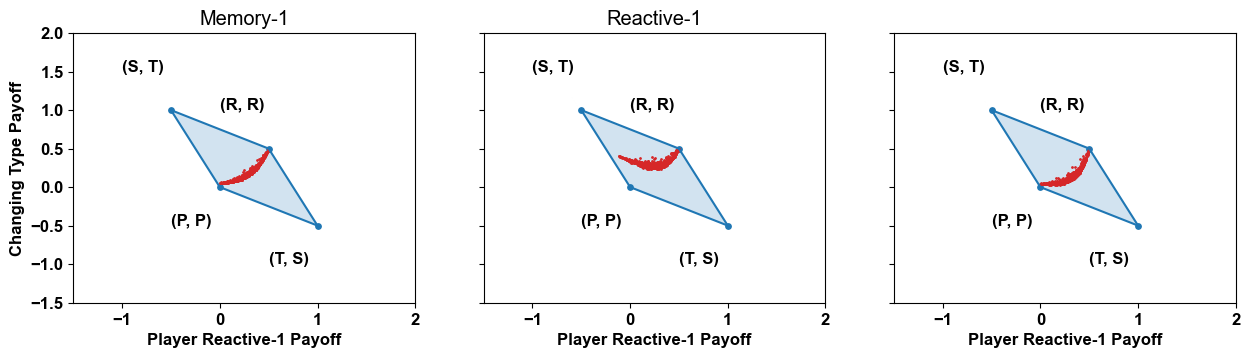

In [94]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3.5), sharex=True, sharey=True)

for ax in axes:
    ax = default_plot(ax, [b - c, -c, b, 0])
    ax.set_xlabel("Player Reactive-1 Payoff")

axes[0].set_ylabel("Changing Type Payoff")

axes[0].scatter(X, Y, s=1, color="tab:red")
axes[0].set_title("Memory-1")

axes[1].scatter(X1, Y1, s=1, color="tab:red")
axes[1].set_title("Reactive-1")

axes[2].scatter(X2, Y2, s=1, color="tab:red")
axes[1].set_title("Reactive-1")

### Evolution over Seeds

In [11]:
def one_bit_condition_one(p1, p2, c, b):
    return p2 < 1 - c / b


def one_bit_condition_two(p1, p2, c, b):
    return p1 > 0.95


def is_partner_one_bit(p1, p2, c, b):
    return (one_bit_condition_one(p1, p2, c, 1)) and (
        one_bit_condition_two(p1, p2, c, 1)
    )

In [12]:
def two_bit_condition_one(p1, p2, p3, p4, c, b):
    return p4 < (1 - c / b)


def two_bit_condition_two(p1, p2, p3, p4, c, b):
    return p2 + p3 < (2 - c / b)


def two_bit_condition_three(p1, p2, p3, p4, c, b):
    return p1 > 0.95


def is_partner_two_bits(p1, p2, p3, p4, c, b):
    return (
        (two_bit_condition_one(p1, p2, p3, p4, c, 1))
        and two_bit_condition_two(p1, p2, p3, p4, c, 1)
        and two_bit_condition_three(p1, p2, p3, p4, c, 1)
    )

In [13]:
reactive_abundant = pd.read_csv(
    "../prc_data/evolution_over_seeds_reactive_new.csv", index_col=0
)

In [173]:
dists = []

reactive = []


for type_, variables in zip(
    ["one", "two", "three"],
    [
        ["p_1", "p_2", "frequencies"],
        ["p_1", "p_2", "p_3", "p_4", "frequencies"],
        ["p_1", "p_2", "p_3", "p_4", "p_5", "p_6", "p_7", "p_8", "frequencies"],
    ],
):
    groups = reactive_abundant[
        (reactive_abundant["type"] == type_) & (reactive_abundant["p_1"] > 0.95)
    ].groupby("seed")

    per_seed = []

    for _, group in groups:
        index = group["frequencies"].idxmax()
        per_seed.append(tuple(group[group.index == index][variables].values[0]))

    ps = list(zip(*per_seed))

    reactive.append(ps[:-1])
    
dists.append(reactive)

In [174]:
spacing = np.linspace(-0.1, 0.1, 20)

evens = np.arange(1, 17, 1)

In [176]:
colors_dic = {
    "R1": "tab:orange",
    "R2": "tab:green",
    "R3": "tab:blue",
    "R4": "chocolate",
    "R5": "yellowgreen",
    "R6": "dodgerblue",
}

colors = [
    "tab:orange",
    "tab:green",
    "tab:blue",
    "chocolate",
    "yellowgreen",
    "dodgerblue",
]

linestyles = ["-o", "--o", ":o"]

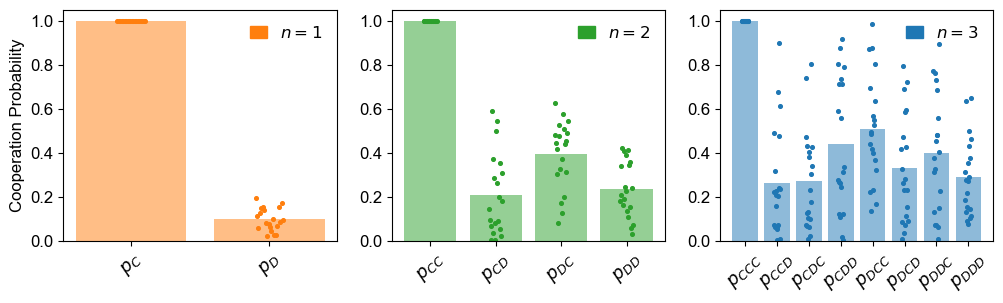

In [188]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))

for j, dist in enumerate(dists[0]):
    averages = np.mean(dist, axis=1)


    for l, data in enumerate(dist):
        for l2, point in enumerate(data):
            _ = axes[j].scatter(
                0 + evens[l] + spacing[l2],
                point,
                color=colors_dic[f"R{j + 1}"],
                s=7,
                zorder=2,
            )
        _ = axes[j].bar(
            evens[l],
            averages[l],
            color=colors_dic[f"R{j + 1}"],
            alpha=0.5,)
        
        
    if j == 0:
        axes[j].set_ylabel("Cooperation Probability", fontweight="normal")

        axes[j].set_xticks([1, 2])
        axes[j].set_xticklabels(["$p_C$", "$p_D$"], rotation=45, fontsize=13)
    if j == 1:
        axes[j].set_xticks([1, 2, 3, 4])
        axes[j].set_xticklabels(
            ["$p_{CC}$", "$p_{CD}$", "$p_{DC}$", "$p_{DD}$"],
            rotation=45,
            fontsize=13,
        )
    if j == 2:
        axes[j].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
        axes[j].set_xticklabels(
            [
                "$p_{CCC}$",
                "$p_{CCD}$",
                "$p_{CDC}$",
                "$p_{CDD}$",
                "$p_{DCC}$",
                "$p_{DCD}$",
                "$p_{DDC}$",
                "$p_{DDD}$",
            ],
            rotation=45,
            fontsize=13,
        )
        
    label = [
            (
                mpatches.Patch(color=colors_dic[f"R{j + 1}"]),
                f"$n={j + 1}$",
            )
        ]

    axes[j].legend(
        *zip(*label),
#         bbox_to_anchor=(1.03, 1.01),
        handlelength=1,
        fontsize=12,
        frameon=False,
    )

fig.savefig("../figures/siFig3AbundantStrategies.pdf", bbox_inches="tight")

In [189]:
one_df = reactive_abundant[reactive_abundant['type'] == 'one']

In [190]:
ispartner = []

for i, row in tqdm(one_df.iterrows()):
    condition = is_partner_one_bit(row["p_1"], row["p_2"], 1/2, 1)

    ispartner.append(condition)

0it [00:00, ?it/s]

In [192]:
len(ispartner), len(one_df)

(792110, 792110)

In [191]:
one_df['ispartner'] = ispartner

In [193]:
groups = one_df.groupby('seed')

top = []

for i, group in groups:
    top.append(group.sort_values('frequencies').iloc[-1])

In [224]:
top_one = pd.DataFrame(top)

In [226]:
top_one['p_1'] = top_one['p_1'].round(2)

In [230]:
top_one = top_one.sort_values(['p_1', 'p_2'], ascending=False)

In [265]:
invaders = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.05.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [266]:
invaders1 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.49.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [267]:
invaders2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.1.csv",
                       header=None, names=["p", "q", "num", "coop"])

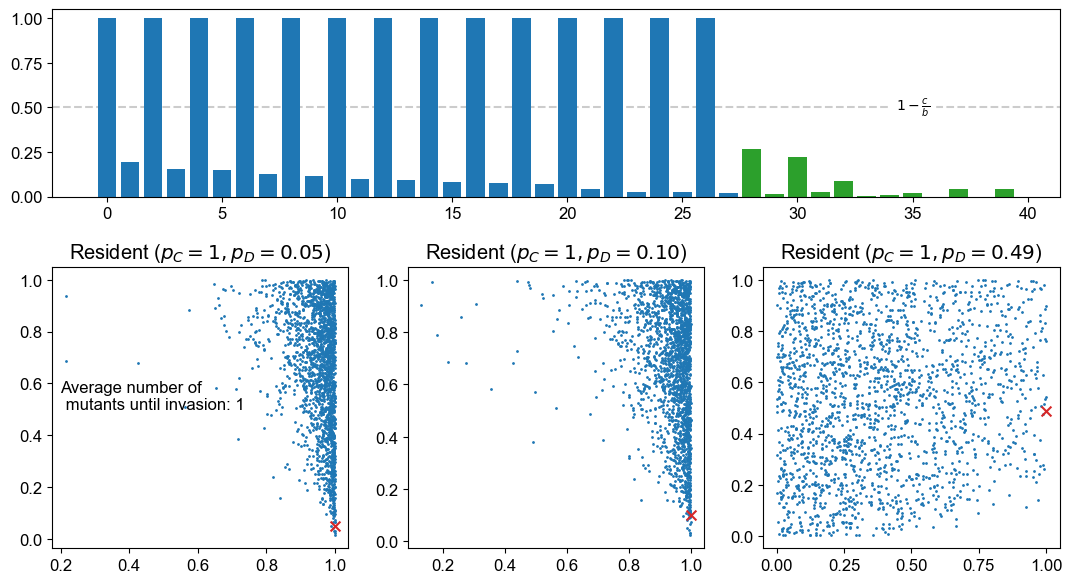

In [306]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("AAA;BCD", figsize=(13, 7), gridspec_kw = {'height_ratios':[1, 1.5]})

j = 0

for i, row in top_one.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    axes["A"].bar([j + 0, j + 1], [row['p_1'], row['p_2']], color=c)
    
    j += 2
    
axes["A"].axhline(0.5, linestyle='--', color='black', alpha=.2, zorder=-1)

axes["A"].text(35, 0.5, r'$1 - \frac{c}{b}$', fontsize=10, va='center', ha='center', backgroundcolor='w');


axes["B"].scatter(invaders["p"], invaders["q"], s=1);
axes["B"].scatter(1, 0.05, s=50, marker='x', color='tab:red');
axes["B"].set_title("Resident ($p_{C} = 1, p_{D} = 0.05$)");
axes["B"].text(0.2, .5, f'Average number of \n mutants until invasion: {1}')

axes["C"].scatter(invaders2["p"], invaders2["q"], s=1);
axes["C"].scatter(1, 0.10, s=50, marker='x', color='tab:red');
axes["C"].set_title("Resident ($p_{C} = 1, p_{D} = 0.10$)");

axes["D"].scatter(invaders1["p"], invaders1["q"], s=1);
axes["D"].scatter(1, 0.49, s=50, marker='x', color='tab:red');
axes["D"].set_title("Resident ($p_{C} = 1, p_{D} = 0.49$)");

fig.subplots_adjust(hspace=.3)

In [279]:
fig.subplots_adjust?

**How many of tops are partners?**

In [30]:
len(count), sum(count)

(20, 14)

In [84]:
invaders = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.05.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [85]:
invaders1 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.49.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [86]:
invaders2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.1.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [90]:
invaders['num'].mean(), invaders1['num'].mean(), invaders2['num'].mean()

(2815.9540229885056, 42.77811094452774, 2347.984007996002)

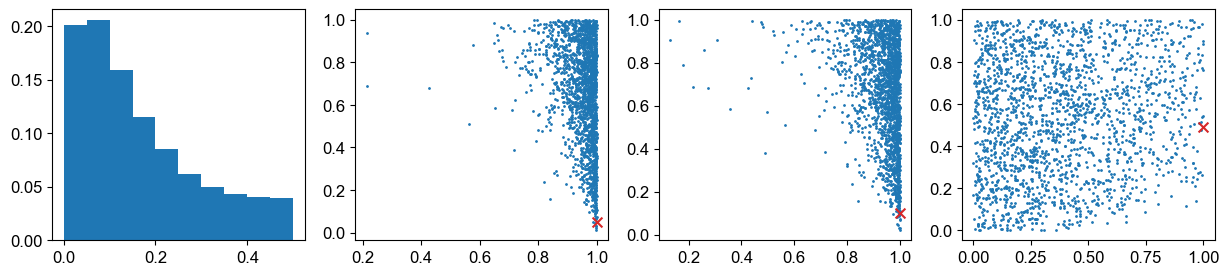

In [34]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 3))


p2s = one_df[one_df['ispartner'] == True]['p_2']

weights = np.ones_like(p2s) / len(p2s)

axes[0].hist(p2s, weights=weights);

axes[1].scatter(invaders["p"], invaders["q"], s=1);
axes[1].scatter(1, 0.05, s=50, marker='x', color='tab:red');

axes[2].scatter(invaders2["p"], invaders2["q"], s=1);
axes[2].scatter(1, 0.10, s=50, marker='x', color='tab:red');

axes[3].scatter(invaders1["p"], invaders1["q"], s=1);
axes[3].scatter(1, 0.49, s=50, marker='x', color='tab:red');

In [35]:
one_df['ispartner'].value_counts()

False    733334
True      58776
Name: ispartner, dtype: int64

In [36]:
one_df.sort_values('frequencies')[-50:]['ispartner'].value_counts()

True     34
False    16
Name: ispartner, dtype: int64

## Reactive-2 

In [37]:
two_df = reactive_abundant[reactive_abundant['type'] == 'two']

In [38]:
ispartner = []

for i, row in tqdm(two_df.iterrows()):
    
    condition = is_partner_two_bits(
        row["p_1"], row["p_2"], row["p_3"], row["p_4"], 1/2, 1
    )
    ispartner.append(condition)

0it [00:00, ?it/s]

In [39]:
len(ispartner), len(two_df)

(877409, 877409)

In [40]:
two_df['ispartner'] = ispartner

**How many top are partners?**

In [99]:
groups = two_df.groupby('seed')

count = []
top_s = []

for i, group in groups:
    count.append(group.sort_values('frequencies').iloc[-1]['ispartner'])
    
    top_s.append(group.sort_values('frequencies').iloc[-1][['p_1', 'p_2', 'p_3', 'p_4']])

In [43]:
len(count), sum(count)

(20, 13)

In [100]:
top_s

[p_1    0.998117
 p_2    0.146366
 p_3    0.628284
 p_4    0.180032
 Name: 279, dtype: object,
 p_1    0.119331
 p_2    0.000067
 p_3    0.993604
 p_4    0.026292
 Name: 22399, dtype: object,
 p_1    0.998909
 p_2    0.004594
 p_3      0.4449
 p_4    0.209839
 Name: 41328, dtype: object,
 p_1    0.999829
 p_2    0.065105
 p_3    0.417832
 p_4    0.422934
 Name: 34659, dtype: object,
 p_1    0.105596
 p_2    0.000393
 p_3     0.99702
 p_4     0.02317
 Name: 11538, dtype: object,
 p_1    0.025178
 p_2    0.023779
 p_3    0.993497
 p_4    0.092232
 Name: 41984, dtype: object,
 p_1    0.999834
 p_2    0.036668
 p_3      0.4779
 p_4    0.188633
 Name: 37777, dtype: object,
 p_1     0.21404
 p_2    0.008268
 p_3    0.992569
 p_4    0.039818
 Name: 18107, dtype: object,
 p_1    0.999668
 p_2    0.079571
 p_3    0.324206
 p_4    0.225941
 Name: 8116, dtype: object,
 p_1      0.0148
 p_2    0.033771
 p_3    0.993987
 p_4    0.084243
 Name: 27712, dtype: object,
 p_1    0.999229
 p_2    0.498073

In [44]:
two_df = two_df.sort_values('frequencies')

In [49]:
top = two_df[two_df['frequencies'] > 6000]

In [55]:
p2s = two_df[two_df['ispartner'] == True]['p_2']
p3s = two_df[two_df['ispartner'] == True]['p_3']
p4s = two_df[two_df['ispartner'] == True]['p_4']

In [64]:
two_df.head()

,p_1,p_2,t,cooperation,type,seed,frequencies,frequencies norm,p_3,p_4,p_5,p_6,p_7,p_8,ispartner
18033,0.720381,0.752551,4223626,0.616536,two,8,1,1.000000e-07,0.327872,0.610666,NaN,NaN,NaN,NaN,False
38980,0.682990,0.625866,9016003,0.698229,two,8,1,1.000000e-07,0.832754,0.632334,NaN,NaN,NaN,NaN,False
18942,0.129594,0.613381,4275486,0.279562,two,3,1,1.000000e-07,0.316952,0.156698,NaN,NaN,NaN,NaN,False
38947,0.522480,0.936188,9008131,0.479677,two,8,1,1.000000e-07,0.084193,0.331284,NaN,NaN,NaN,NaN,False
18954,0.811190,0.672196,4277743,0.509460,two,3,1,1.000000e-07,0.663229,0.033582,NaN,NaN,NaN,NaN,False


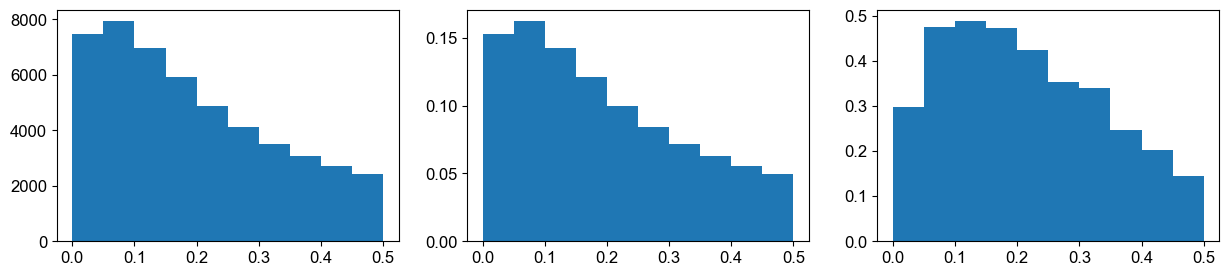

In [67]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 3))

ax[0].hist(p4s);

weights = np.ones_like(p4s) / len(p4s)

ax[1].hist(p4s, weights=weights);


ax[2].hist(p4s, weights=two_df[two_df['ispartner'] == True]['frequencies norm']);

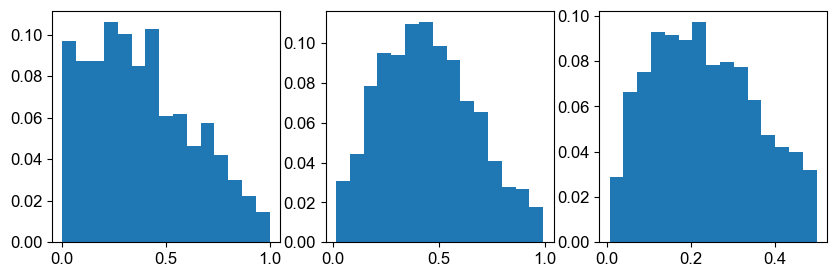

In [51]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 3))

weights = np.ones_like(p2s) / len(p2s)

h1 = axes[0].hist(p2s, weights=weights, bins=15);

weights = np.ones_like(p3s) / len(p3s)

h2 = axes[1].hist(p3s, weights=weights, bins=15);

weights = np.ones_like(p4s) / len(p4s)

h3 = axes[2].hist(p4s, weights=weights, bins=15);

In [117]:
files = ['../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.05_p3_0.6_p4_0.3.csv',
 '../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.6_p3_0.05_p4_0.3.csv',
'../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.05_p3_0.6_p4_0.1.csv',
 '../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.6_p3_0.05_p4_0.1.csv']

In [121]:
invaders = [pd.read_csv(file,
                       header=None, names=["p1", "p2", "p3", "p4", "num", "coop"]) for file in files]

In [122]:
invaders[0]

,p1,p2,p3,p4,num,coop
0,1.000000,0.050000,0.600000,0.300000,0,0.000000
1,0.976101,0.476680,0.912576,0.793678,3476,0.948824
2,0.985954,0.908740,0.698869,0.412776,1368,0.977529
3,0.952704,0.394473,0.755102,0.907765,25260,0.874360
4,0.989817,0.868745,0.512118,0.463805,33337,0.975054
...,...,...,...,...,...,...
996,0.991722,0.831177,0.453582,0.281310,32798,0.972353
997,0.989741,0.463403,0.827455,0.665188,1985,0.971366
998,0.994031,0.357606,0.338179,0.601525,12748,0.921620
999,0.996851,0.652066,0.329468,0.398187,6976,0.973559


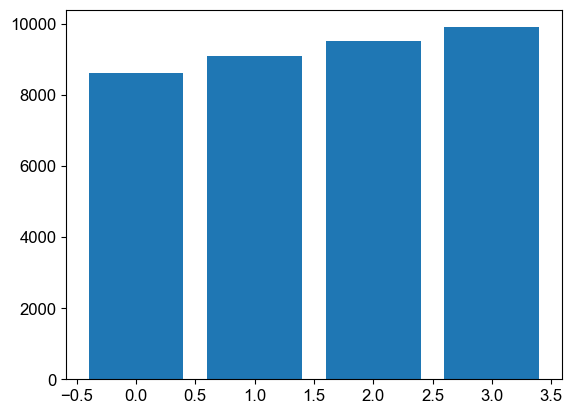

In [124]:
fig, ax = plt.subplots()

bars = [inv['num'].median() for inv in invaders]

ax.bar(range(4), bars);

**Invading**

In [165]:
files = ['../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.05_p3_0.6_p4_0.3.csv',
          '../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.6_p3_0.05_p4_0.3.csv',
 '../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.05_p3_0.6_p4_0.1.csv',
 '../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.6_p3_0.05_p4_0.1.csv']

In [166]:
invading = [pd.read_csv(file, names = ['p1', 'p2', 'p3', 'p4', 'i', 'coop', 'invaded']) for file in files]

In [167]:
[inv['invaded'].sum() for inv in invading]

[42, 41, 58, 55]

In [168]:
invading[0]['invaded'].count()

1001

In [169]:
invading[0]

,p1,p2,p3,p4,i,coop,invaded
0,1.000000,0.050000,0.600000,0.300000,0,0.000000,0
1,0.417022,0.720324,0.000114,0.302333,1,0.341830,0
2,0.092339,0.186260,0.345561,0.396767,2,0.311079,0
3,0.419195,0.685219,0.204452,0.878117,3,0.531695,1
4,0.670468,0.417305,0.558690,0.140387,4,0.372193,0
...,...,...,...,...,...,...,...
996,0.489336,0.486921,0.570292,0.544508,996,0.521569,0
997,0.884385,0.783719,0.322727,0.784437,997,0.753446,0
998,0.860226,0.773000,0.775967,0.528699,998,0.824991,0
999,0.226631,0.808678,0.965929,0.543532,999,0.589865,0
